## Convolutional Neural Network for MNIST image classficiation 

In [5]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Alternating Least Squares for Matrix Factorization

In [185]:
def coding_within_radius(X, W, H0, 
                         r=None, 
                         alpha=0, 
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + alpha|H| ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + alpha * np.ones(len(idx)))
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size

            if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

In [186]:
def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), alpha=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, alpha=a1, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

In [205]:
# Simulated Data and its factorization 

W0 = np.random.rand(10,5)
H0 = np.random.rand(5,20)
X0 = W0 @ H0

W, H = ALS(X=X0, 
           n_components=5, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

print('reconstruction error (relative) = %f' % (np.linalg.norm(X0-W@H)**2/np.linalg.norm(X0)**2))
print('Dictionary error (relative) = %f' % (np.linalg.norm(W0 - W)**2/np.linalg.norm(W0)**2))
print('Code error (relative) = %f' % (np.linalg.norm(H0-H)**2/np.linalg.norm(H0)**2))


 75%|███████▌  | 75/100 [00:00<00:00, 354.48it/s]

iteration 0, reconstruction error 6.850484
iteration 10, reconstruction error 0.184030
iteration 20, reconstruction error 0.115189
iteration 30, reconstruction error 0.070010
iteration 40, reconstruction error 0.037359
iteration 50, reconstruction error 0.018744
iteration 60, reconstruction error 0.009585
iteration 70, reconstruction error 0.005230


100%|██████████| 100/100 [00:00<00:00, 375.81it/s]

iteration 80, reconstruction error 0.003022
iteration 90, reconstruction error 0.001825
reconstruction error (relative) = 0.000003
Dictionary error (relative) = 0.718137
Code error (relative) = 0.380758


# Learn dictionary of MNIST images 

In [136]:
def display_dictionary(W):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 6),
                            subplot_kw={'xticks': [], 'yticks': []})
    for ax, i in zip(axs.flat, range(100)):
        ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
       
    plt.tight_layout()
    plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.show()

In [43]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

 10%|█         | 2/20 [00:00<00:03,  5.11it/s]

iteration 0, reconstruction error 4769.103915


 60%|██████    | 12/20 [00:02<00:01,  5.50it/s]

iteration 10, reconstruction error 2003.858100


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


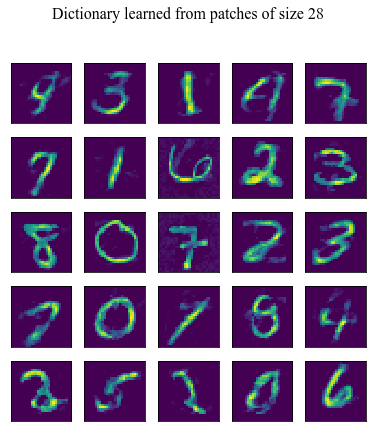

In [139]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=20, 
           subsample_ratio=1, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           compute_recons_error=True)

display_dictionary(W)

In [143]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [144]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

  1%|          | 1/100 [00:00<00:25,  3.85it/s]

iteration 0, reconstruction error 6509.566346


 11%|█         | 11/100 [00:02<00:22,  3.89it/s]

iteration 10, reconstruction error 3768.970476


 21%|██        | 21/100 [00:05<00:20,  3.93it/s]

iteration 20, reconstruction error 3130.597074


 31%|███       | 31/100 [00:08<00:17,  3.83it/s]

iteration 30, reconstruction error 2934.072988


 41%|████      | 41/100 [00:10<00:13,  4.37it/s]

iteration 40, reconstruction error 2836.996494


 51%|█████     | 51/100 [00:12<00:10,  4.66it/s]

iteration 50, reconstruction error 2795.095887


 61%|██████    | 61/100 [00:14<00:07,  4.96it/s]

iteration 60, reconstruction error 2716.070430


 71%|███████   | 71/100 [00:16<00:06,  4.47it/s]

iteration 70, reconstruction error 2689.920892


 81%|████████  | 81/100 [00:18<00:03,  4.91it/s]

iteration 80, reconstruction error 2676.593157


 91%|█████████ | 91/100 [00:21<00:01,  4.69it/s]

iteration 90, reconstruction error 2665.760225


100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


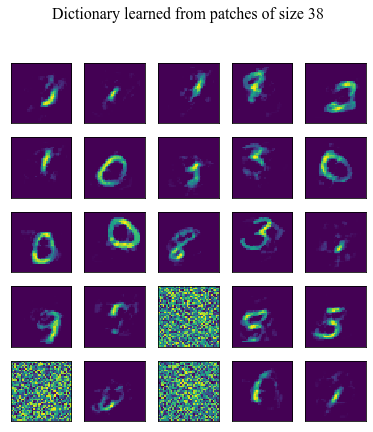

In [187]:
# Simple MNIST binary classification experiments 

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=10)

idx = np.random.choice(np.arange(X_train.shape[1]), 100)

X0 = X_train[idx,:].T
W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=100, 
           subsample_ratio=1, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           compute_recons_error=True)

display_dictionary(W)


## Dictionary Learing for Face datasets

In [200]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
#faces_centered = faces - faces.mean(axis=0)

# local centering
#faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces_centered.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)


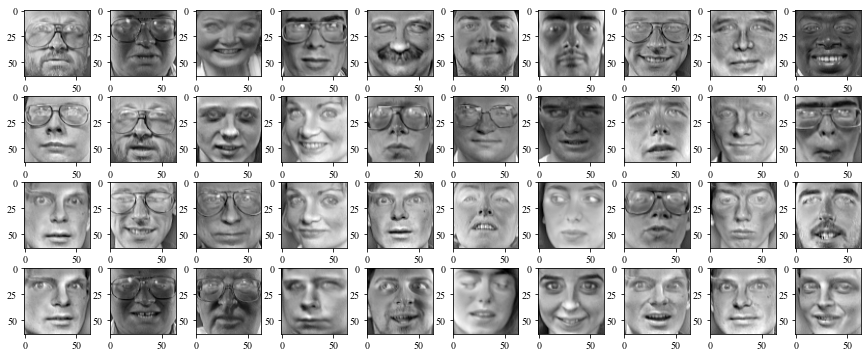

In [201]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        ax[i,j].imshow(faces_centered[i*ncols + j].reshape(64,64), cmap="gray")
        #if i == 0:
        #    ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('Faces_ex1.pdf', bbox_inches='tight')

  2%|▏         | 1/50 [00:00<00:27,  1.77it/s]

iteration 0, reconstruction error 69052.431400


 22%|██▏       | 11/50 [00:04<00:15,  2.54it/s]

iteration 10, reconstruction error 16029.395168


 42%|████▏     | 21/50 [00:08<00:11,  2.58it/s]

iteration 20, reconstruction error 12972.342575


 62%|██████▏   | 31/50 [00:12<00:07,  2.56it/s]

iteration 30, reconstruction error 11648.747650


 82%|████████▏ | 41/50 [00:16<00:03,  2.73it/s]

iteration 40, reconstruction error 10819.470759


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


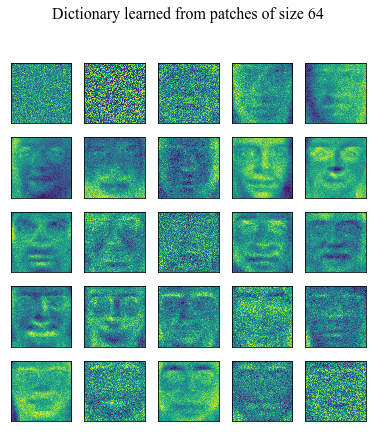

In [202]:
X0 = faces_centered.T
#X0 /= 100 * np.linalg.norm(X0)

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           W_nonnegativity=False,
           H_nonnegativity=False,
           compute_recons_error=True)

display_dictionary(W)



  2%|▏         | 1/50 [00:00<00:20,  2.36it/s]

iteration 0, reconstruction error 28400.931189


 22%|██▏       | 11/50 [00:04<00:15,  2.47it/s]

iteration 10, reconstruction error 13036.661705


 42%|████▏     | 21/50 [00:08<00:11,  2.50it/s]

iteration 20, reconstruction error 8892.326577


 62%|██████▏   | 31/50 [00:11<00:06,  2.75it/s]

iteration 30, reconstruction error 7790.663812


 82%|████████▏ | 41/50 [00:15<00:03,  2.70it/s]

iteration 40, reconstruction error 7058.495699


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


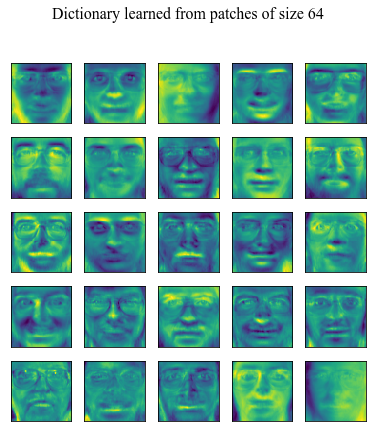

In [203]:
X0 = faces_centered.T
#X0 /= 100 * np.linalg.norm(X0)

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           W_nonnegativity=False,
           H_nonnegativity=True,
           compute_recons_error=True)

display_dictionary(W)



  1%|          | 1/100 [00:00<00:40,  2.45it/s]

iteration 0, reconstruction error 28415.936054


 11%|█         | 11/100 [00:04<00:35,  2.48it/s]

iteration 10, reconstruction error 23693.386017


 21%|██        | 21/100 [00:08<00:29,  2.68it/s]

iteration 20, reconstruction error 22994.667383


 31%|███       | 31/100 [00:11<00:25,  2.70it/s]

iteration 30, reconstruction error 22679.549540


 41%|████      | 41/100 [00:15<00:21,  2.75it/s]

iteration 40, reconstruction error 22429.919728


 51%|█████     | 51/100 [00:19<00:18,  2.68it/s]

iteration 50, reconstruction error 22324.683501


 61%|██████    | 61/100 [00:22<00:14,  2.77it/s]

iteration 60, reconstruction error 22244.012077


 71%|███████   | 71/100 [00:26<00:10,  2.72it/s]

iteration 70, reconstruction error 22147.522618


 81%|████████  | 81/100 [00:30<00:07,  2.70it/s]

iteration 80, reconstruction error 22105.394832


 91%|█████████ | 91/100 [00:33<00:03,  2.72it/s]

iteration 90, reconstruction error 22078.121220


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


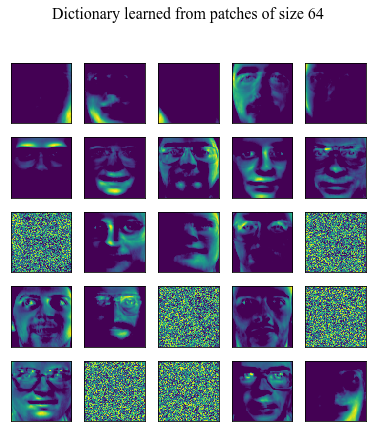

In [204]:
X0 = faces_centered.T
#X0 /= 100 * np.linalg.norm(X0)

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=100, 
           subsample_ratio=1, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=True,
           compute_recons_error=True)

display_dictionary(W)

